In [3]:
## Cross-validation with GSE180286 dataset with percent.mito
## using saved model from GSE176078 new one

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import joblib

# Load trained model with percent.mito
#model_path = "/content/drive/MyDrive/Capstone (Haider, Rajeev)/ghost-cell-busters/xgb_model_mito_14July.pkl"

model_path = "/content/drive/MyDrive/Capstone (Haider, Rajeev)/ghost-cell-busters/xgb_model_mito_17July.pkl"
xgb_model = joblib.load(model_path)

# Load GSE180286 dataset WITH 'percent.mito'
#data_path = "/content/drive/MyDrive/Capstone (Haider, Rajeev)/ghost-cell-busters/GSE180286_obs_features.csv"

#data_path = "/content/drive/MyDrive/Capstone (Haider, Rajeev)/ghost-cell-busters/GSE180286_obs_features_new_14July.csv"

data_path = "/content/drive/MyDrive/Capstone (Haider, Rajeev)/ghost-cell-busters/GSE180286_obs_features_new_16July.csv"
df_val1 = pd.read_csv(data_path)

# Define features used in model
features = [
    "apoptosis_score", "oxphos_score",
    "pct_counts_ribo", "nCount_RNA", "cnv_score",
    "proto_oncogenescore", "S_score", "G2M_score","percent.mito"
]

# Drop missing values and predict
df_val1 = df_val1.dropna(subset=features)

# Use model's internal feature order
X_val = df_val1[xgb_model.feature_names_in_]

# Predict
df_val1["tumor_prob_mito"] = xgb_model.predict_proba(X_val)[:, 1]
df_val1["tumor_pred_mito"] = (df_val1["tumor_prob_mito"] > 0.5).astype(int)
df_val1["tumor_pred_label_mito"] = df_val1["tumor_pred_mito"].map({0: "Predicted Normal", 1: "Predicted Tumor"})

# ✅ Data is ready for further analysis in memory
print("✅ Predictions completed and stored in df_val1.")

✅ Predictions completed and stored in df_val1.


In [6]:
df_val1.head(5)

,Unnamed: 0,sample,file,percent.mito,cnv_reference,cnv_score,nCount_RNA,pct_counts_ribo,S_score,G2M_score,phase,oxphos_score,apoptosis_score,proto_oncogenescore,tumor_prob_mito,tumor_pred_mito,tumor_pred_label_mito
0,GGATAAGGGTCA-GSM5457199,GSM5457199,GSM5457199,0.0,normal,3.085859,47478,18.918236,0.124871,-1.576374,S,19.656475,-0.742857,19.656475,0.999821,1,Predicted Tumor
1,CCGTGCGTACTG-GSM5457199,GSM5457199,GSM5457199,0.0,normal,2.003530,30785,18.080234,0.444978,0.286940,S,15.979866,-1.411607,15.979866,1.000000,1,Predicted Tumor
2,AGGTAACCTACG-GSM5457199,GSM5457199,GSM5457199,0.0,normal,1.520273,23314,14.184610,0.414268,0.548015,G2M,8.738379,-1.065893,8.738379,0.999999,1,Predicted Tumor
3,CTGTATAACCTA-GSM5457199,GSM5457199,GSM5457199,0.0,normal,1.310010,20320,18.794291,0.021413,-0.888731,S,4.737882,0.645179,4.737882,0.999671,1,Predicted Tumor
4,AAACAGGTTTGA-GSM5457199,GSM5457199,GSM5457199,0.0,normal,1.156577,17989,16.059814,0.585813,0.239374,S,3.516406,0.143929,3.516406,0.999993,1,Predicted Tumor


In [7]:
# List of features used in the model
features = [
    "apoptosis_score", "oxphos_score",
    "pct_counts_ribo", "nCount_RNA", "cnv_score",
    "proto_oncogenescore", "S_score", "G2M_score", "percent.mito"
]

# Group by predicted tumor class and compute mean
grouped_summary = df_val1.groupby("tumor_pred_mito")[features].mean().T
grouped_summary.columns = ["Predicted Normal (0)", "Predicted Tumor (1)"]

# Print results
print("📊 Mean Feature Values by Predicted Tumor Class:")
print(grouped_summary.round(4))

📊 Mean Feature Values by Predicted Tumor Class:
                     Predicted Normal (0)  Predicted Tumor (1)
apoptosis_score                   -0.0083              -0.0567
oxphos_score                      -0.1335              -0.1014
pct_counts_ribo                   32.2534              20.2454
nCount_RNA                       502.6880            2134.4714
cnv_score                          0.0310               0.1349
proto_oncogenescore               -0.1335              -0.1014
S_score                           -0.0046               0.0006
G2M_score                         -0.0448              -0.0457
percent.mito                       0.0000               0.0000


In [8]:
from scipy.stats import ttest_ind

# Define your features to test
features = [
    "apoptosis_score", "oxphos_score", "pct_counts_ribo", "nCount_RNA",
    "cnv_score", "proto_oncogenescore", "S_score", "G2M_score","percent.mito"
]

# Create groups
group0 = df_val1[df_val1["tumor_pred_mito"] == 0]
group1 = df_val1[df_val1["tumor_pred_mito"] == 1]

# Run t-tests and collect results
results = []
for feature in features:
    t_stat, p_val = ttest_ind(group0[feature], group1[feature], equal_var=False)
    results.append({
        "feature": feature,
        "mean_group0": group0[feature].mean(),
        "mean_group1": group1[feature].mean(),
        "t_stat": t_stat,
        "p_value": p_val
    })

# Convert to DataFrame and sort by p-value
t_test_results = pd.DataFrame(results).sort_values("p_value")

# Display results
t_test_results

,feature,mean_group0,mean_group1,t_stat,p_value
0,apoptosis_score,-0.008326,-0.056691,51.240177,0.000000e+00
2,pct_counts_ribo,32.253417,20.245412,218.117267,0.000000e+00
3,nCount_RNA,502.687995,2134.471397,-170.635869,0.000000e+00
4,cnv_score,0.030982,0.134901,-170.437164,0.000000e+00
6,S_score,-0.004591,0.000603,-8.708723,3.136045e-18
1,oxphos_score,-0.133492,-0.101438,-8.543091,1.330694e-17
5,proto_oncogenescore,-0.133492,-0.101438,-8.543091,1.330694e-17
7,G2M_score,-0.044831,-0.045720,0.477931,6.327004e-01
8,percent.mito,0.000000,0.000000,NaN,NaN


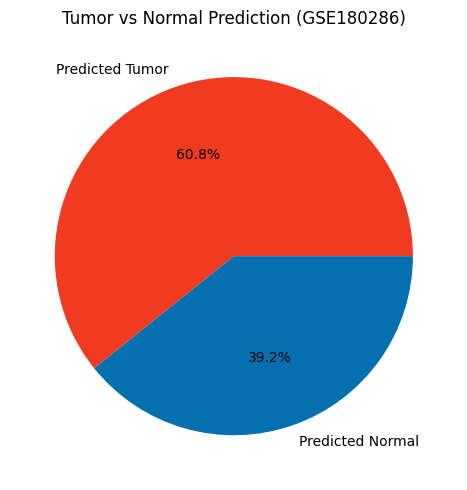

In [9]:
import matplotlib.pyplot as plt
df_val1["tumor_pred_label_mito"].value_counts().plot.pie(
    autopct="%1.1f%%",
    colors=["#f03b20", "#0570b0"],
    figsize=(5, 5)
)
plt.title("Tumor vs Normal Prediction (GSE180286)")
plt.ylabel("")
plt.tight_layout()
plt.show()

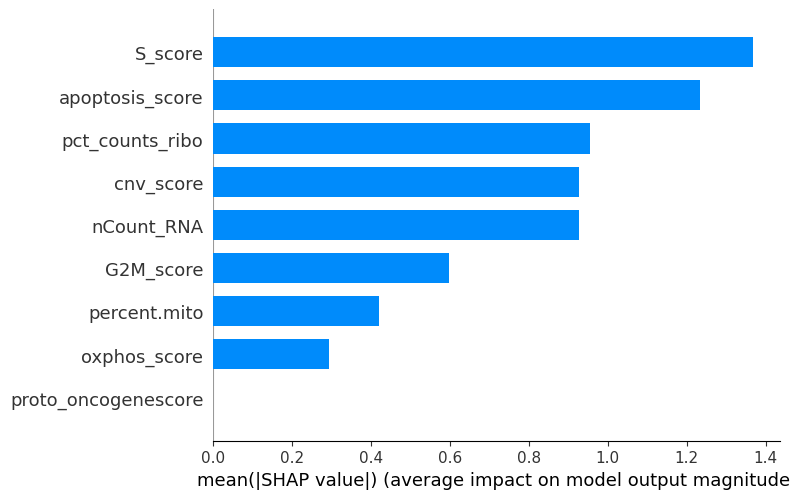

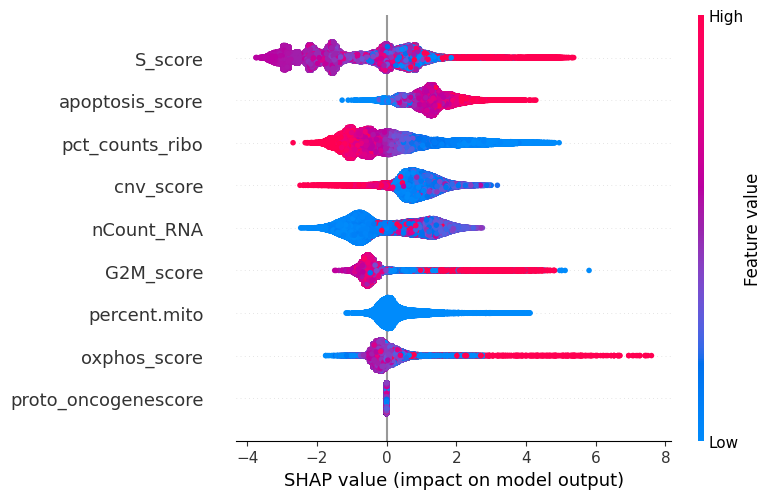

In [10]:
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt


# Features used in the model
features = [
    "apoptosis_score", "oxphos_score",
    "pct_counts_ribo", "nCount_RNA", "cnv_score",
    "proto_oncogenescore", "S_score", "G2M_score", "percent.mito"
]
df_val1 = df_val1.dropna(subset=features)
X_val = df_val1[features]

# Use TreeExplainer instead of the default (which tries to load GPU deps)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val)

# Bar summary plot
shap.summary_plot(shap_values, X_val, plot_type="bar")

# Beeswarm summary plot
shap.summary_plot(shap_values, X_val)

In [11]:
##df_val1.to_csv("/content/drive/MyDrive/Capstone (Haider, Rajeev)/ghost-cell-busters/GSE180286_predictions_mito_17July.csv", index=True)

In [12]:
df_val1.to_csv("/content/drive/MyDrive/Capstone (Haider, Rajeev)/ghost-cell-busters/GSE180286_predictions_mito_16July.csv", index=True)